이번 페이지에서는 LSTM을 활용하여 주가 예측 모델을 구축하도록 하겠습니다. 

이를 위한 프로세스는 

1. 데이터 받아오기 
2. Tensorflow Dataset 클래스를 활용하여 데이터 전처리하기 
3. LSTM을 활용하여 주가 예측 모델 구축 및 평가하기

로 구성이 되어 있습니다. 

In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
import warnings 
import os 

%matplotlib inline 
warnings.filterwarnings('ignore')

In [2]:
# 삼성전자 데이터 받아오기 
%run data_reader.py

In [3]:
samsung['Year'] = samsung.index.year
samsung['Month'] = samsung.index.month
samsung['day'] = samsung.index.day

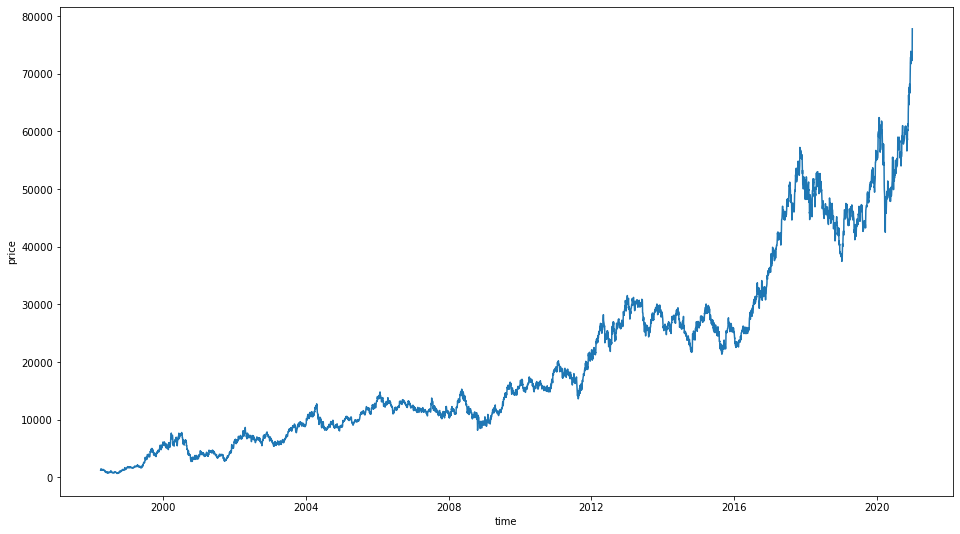

In [4]:
plt.figure(figsize=[16,9])
plt.plot(samsung.Close)
plt.xlabel("time")
plt.ylabel("price")
plt.show()

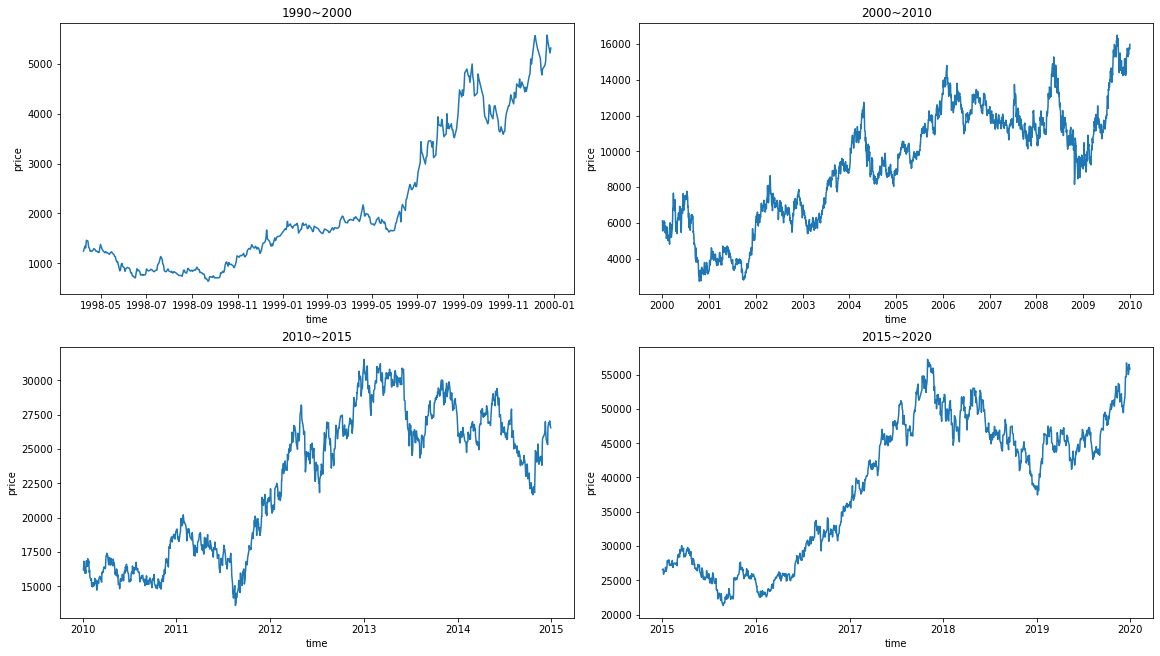

In [5]:
time_steps =[['1990','2000'],['2000','2010'],['2010','2015'],['2015','2020']]
fig,axes =plt.subplots(2,2,figsize=[16,9],constrained_layout=True)
for i in range(4):
    ax = axes[i//2,i%2]
    df = samsung.loc[(samsung.index>time_steps[i][0])&(samsung.index<time_steps[i][1])]
    ax.plot(df.Close)
    ax.set_title(f"{time_steps[i][0]}~{time_steps[i][1]}")
    ax.set_xlabel("time")
    ax.set_ylabel("price")
plt.show()

데이터 전처리 

- 주가 데이터에 대하여 딥러닝 모델이 더 잘 학습할 수 있도록 **정규화**를 해주도록 하겠습니다. 
- 표준화와 정규화 대한 내용은 나중에 더 자세하게 알아보도록 하겠습니다

In [6]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scale_cols = ['Open','High','Low','Close','Volume']

scaled=  scaler.fit_transform(samsung[scale_cols])

In [7]:
df = pd.DataFrame(scaled, columns = scale_cols)

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df.drop('Close',axis=1),df['Close'],test_size=0.2,random_state= 42, shuffle = False)
X_train.shape

(4516, 4)

시계열 데이터의 경우, train_test_split에 있어서 shuffle하지 않도록 주의할 것 

In [9]:
X_test.shape

(1129, 4)

Tensorflow Datast을 활용한 시퀀스 데이터세트 구성

In [10]:
import tensorflow as tf 

def windowed_dataset(series, window_size, batch_size, shuffle):
    series = tf.expand_dims(series,axis= -1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size+1, shift =1 , drop_remainder = True)
    ds =ds.flat_map(lambda w : w.batch(window_size+1))
    if shuffle:
        ds = ds.shuffle(1000)
    ds = ds.map(lambda w: (w[:-1], w[-1]))
    return ds.batch(batch_size).prefetch(1)

window_size = 20
batch_size =32

In [11]:
# trian_data는 학습용 데이터셋, test_data는 검증용 데이터셋 입니다.
train_data = windowed_dataset(y_train, window_size, batch_size, True)
test_data = windowed_dataset(y_test, window_size, batch_size, False)

In [12]:
for data in train_data.take(1):
    print(f'데이터셋(X) 구성(batch_size, window_size, feature갯수): {data[0].shape}')
    print(f'데이터셋(Y) 구성(batch_size, window_size, feature갯수): {data[1].shape}')

데이터셋(X) 구성(batch_size, window_size, feature갯수): (32, 20, 1)
데이터셋(Y) 구성(batch_size, window_size, feature갯수): (32, 1)


In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Conv1D, Lambda
from tensorflow.keras.losses import Huber
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

model = Sequential([
    # 1차원 feature map 생성
    Conv1D(filters=32, kernel_size=5,
           padding="causal",
           activation="relu",
           input_shape=[window_size, 1]),
    # LSTM
    LSTM(16, activation='tanh'),
    Dense(16, activation="relu"),
    Dense(1),
])

# Sequence 학습에 비교적 좋은 퍼포먼스를 내는 Huber()를 사용합니다.
loss = Huber()
optimizer = Adam(0.0005)
model.compile(loss=Huber(),optimizer= optimizer, metrics =["mse"])

In [14]:
# 10번 epoch동안 val_loss 개선이 없다면 학습을 멈춤
early_stopping = EarlyStopping(monitor = "val_loss", patience =10)
filename = os.path.join("models",'checkpointer.ckpt')
checkpoint = ModelCheckpoint(filename, save_weights_only=True, save_best_only=True,monitor= "val_loss", verbose=1)

In [15]:
history = model.fit(train_data, validation_data = (test_data),epochs =50, callbacks= [checkpoint, early_stopping])

Epoch 1/50
    138/Unknown - 3s 9ms/step - loss: 1.0194e-04 - mse: 2.0387e-04
Epoch 1: val_loss improved from inf to 0.00112, saving model to models\checkpointer.ckpt
141/141 [==============================] - 4s 15ms/step - loss: 1.0093e-04 - mse: 2.0186e-04 - val_loss: 0.0011 - val_mse: 0.0022
Epoch 2/50
139/141 [============================>.] - ETA: 0s - loss: 2.5718e-05 - mse: 5.1436e-05
Epoch 2: val_loss did not improve from 0.00112
141/141 [==============================] - 2s 12ms/step - loss: 2.5953e-05 - mse: 5.1905e-05 - val_loss: 0.0012 - val_mse: 0.0025
Epoch 3/50
137/141 [============================>.] - ETA: 0s - loss: 2.5331e-05 - mse: 5.0663e-05
Epoch 3: val_loss did not improve from 0.00112
141/141 [==============================] - 2s 11ms/step - loss: 2.5899e-05 - mse: 5.1798e-05 - val_loss: 0.0014 - val_mse: 0.0027
Epoch 4/50
135/141 [===========================>..] - ETA: 0s - loss: 2.3121e-05 - mse: 4.6242e-05
Epoch 4: val_loss did not improve from 0.00112
141/1

In [16]:
model.load_weights(filename)

In [17]:
filename

'models\\checkpointer.ckpt'

In [18]:
pred = model.predict(test_data)

In [19]:
pred.shape


(1109, 1)

예측 데이터 시각화 

아래 시각화 코드 중 y_test 데이터에 [20:]으로 슬라이싱을 한 이유는 예측 데이터에서 20일치의 데이터로 21일치를 예측해야하기 때문에 test_data로 예측 시 앞의 20일은 예측하지 않습니다. 

따라서, 20번째 index와 비교하면 더욱 정확합니다. 

In [23]:
scaler.transform()

MinMaxScaler()

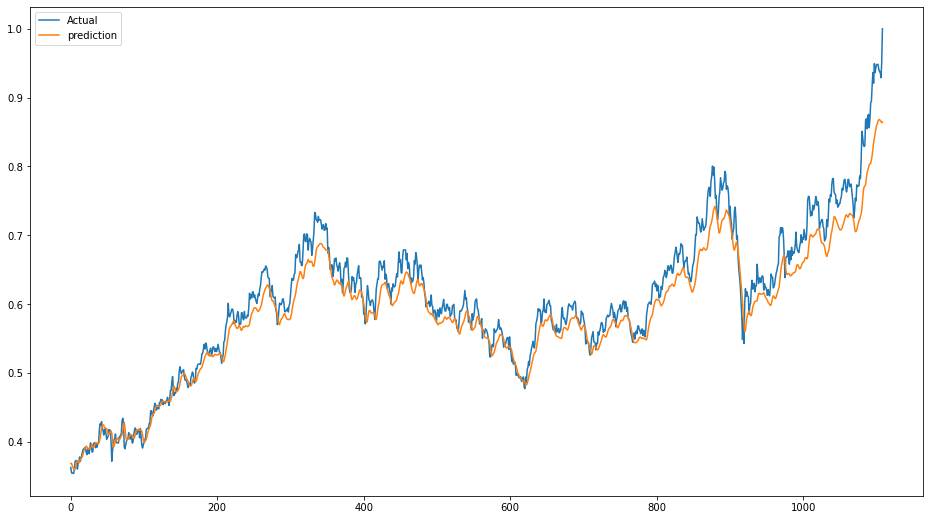

In [20]:
plt.figure(figsize=[16,9])
plt.plot(np.asarray(y_test)[20:],label="Actual")
plt.plot(pred,label = "prediction")
plt.legend()
plt.show()

min-max scaling을 train_test_set로 나누기 이전에 적용했기 떄문에 이 풀이는 data-leakage를 제대로 지키지 못한 풀이라고 생각된다. 

이를 보완한 다른 방법을 가져와서 풀어보자